In [2]:
!pip install pydantic

## Load corpus

In [3]:
from globals import CORPUS_PATH
from utils import load_corpus

In [4]:
corpus = load_corpus(CORPUS_PATH)
corpus[:1]

[{'id': 1,
  'category': 'business',
  'content': 'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the

In [5]:
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from gensim import corpora, models, similarities
from operator import itemgetter

from models import Corpus, Result
from utils import print_resuts

class TFIDFModel:
    def __init__(self, corpus:Corpus, path='/tmp/vsm_docs.mm'):
        self.corpus = corpus
        self.path = path
        self.stopset = set(stopwords.words('english'))
        self.dictionary = self.create_dictionary()
        self.docs2bows()
        self.loaded_corpus = corpora.MmCorpus(path)
        self.tfidf = models.TfidfModel(self.loaded_corpus)

    def preprocess_document(self, doc):
        stemmer = PorterStemmer()
        tokens = wordpunct_tokenize(doc)
        clean = [token.lower() for token in tokens if token.lower() not in self.stopset and len(token) > 2]
        final = [stemmer.stem(word) for word in clean]
        return final

    def create_dictionary(self):
        pdocs = [self.preprocess_document(doc["content"]) for doc in self.corpus]
        dictionary = corpora.Dictionary(pdocs)
        dictionary.save('/tmp/dictionary.dict')  # Saving to a specific path
        return dictionary

    def docs2bows(self):
        docs = [self.preprocess_document(doc['content']) for doc in self.corpus]
        vectors = [self.dictionary.doc2bow(doc) for doc in docs]
        corpora.MmCorpus.serialize(self.path, vectors)
        return vectors

    def get_model(self):
        return self.tfidf, self.dictionary

    def launch_query(self, q, k=5):
        loaded_corpus = corpora.MmCorpus(self.path)
        index = similarities.MatrixSimilarity(loaded_corpus, num_features=len(self.dictionary))
        pq = self.preprocess_document(q)
        vq = self.dictionary.doc2bow(pq)
        qtfidf = self.tfidf[vq]
        sim = index[qtfidf]
        ranking = sorted(enumerate(sim), key=itemgetter(1), reverse=True)
        results = [ Result(id=self.corpus[idx]['id'], content=self.corpus[idx]['content'], category=self.corpus[idx]['category'], score=score)  for idx, score in ranking ]

        print_resuts(results[:k])

        return results


In [6]:
model = TFIDFModel(corpus)

In [7]:
results = model.launch_query("business")

 1. [ Score = 0.506 ] Category politics |  ID: 1423 | Text: uk firms  embracing e-commerce  uk firms are embra
 2. [ Score = 0.350 ] Category business |  ID: 185 | Text: businesses fail to plan for hiv companies fail to 
 3. [ Score = 0.244 ] Category business |  ID: 1151 | Text: rank  set to sell off film unit  leisure group ran
 4. [ Score = 0.243 ] Category business |  ID: 852 | Text: japanese mogul arrested for fraud one of japan s b
 5. [ Score = 0.233 ] Category business |  ID: 1593 | Text: crossrail link  to get go-ahead  the £10bn crossra


In [8]:
str(results[0])

'Document ID: 1423, Category: politics, Score: 0.51\nContent: uk firms  embracing ...'

In [9]:
results[0]

Result(id=1423, content='uk firms  embracing e-commerce  uk firms are embracing internet trading opportunities as never before  e-commerce minister mike o brien says.  a government-commissioned study ranked the uk third in its world index of use of information and communication technology (ict). the report suggests 69% of uk firms are now using broadband and that 30% of micro businesses are trading online. mr o brien said uk businesses were sprinting forward in ict use  but that there were more challenges ahead. the report  carried out independently by consultants booz allen hamilton and hi europe  placed the uk third behind sweden and ireland for business use of ict.  it showed british business brought greater maturity to their ict use  by using broadband in increased numbers  bringing ict into their business plans and using new technologies such as voice activated programmes and desktop video conferences. mr o brien said:  the increase in the proportion of business connected by broad

In [10]:
print(len(results))

2225


# Evaluation

In [11]:
from evaltools import evaluate

In [12]:
categories = ['politics', 'entertainment', 'sport', 'tech', 'business']

In [27]:
method= 'prec_rec' 

In [14]:
import json 
from globals import WORDS_PATH, WORDS_CHAT_PATH

In [15]:
from utils import process_results
from models import Query

## Results One word 

In [16]:
queries_normal = [ Query(category=c, content=c) for c in categories]
queries_normal

[Query(category='politics', content='politics'),
 Query(category='entertainment', content='entertainment'),
 Query(category='sport', content='sport'),
 Query(category='tech', content='tech'),
 Query(category='business', content='business')]

Query 1: category='politics' content='politics'
 1. [ Score = 0.395 ] Category tech |  ID: 982 | Text: online games play with politics after bubbling und
 2. [ Score = 0.331 ] Category sport |  ID: 2111 | Text: kennedy predicts bigger turnout voters   pent up p
 3. [ Score = 0.281 ] Category politics |  ID: 914 | Text: choose hope over fear - kennedy voters will have a
 4. [ Score = 0.254 ] Category sport |  ID: 1801 | Text: teens  know little  of politics teenagers question
 5. [ Score = 0.244 ] Category politics |  ID: 124 | Text: debate needed  on donations cap a cap on donations
-----
Query 2: category='entertainment' content='entertainment'
 1. [ Score = 0.260 ] Category entertainment |  ID: 888 | Text: music mogul fuller sells company pop idol supremo 
 2. [ Score = 0.162 ] Category politics |  ID: 1800 | Text: bbc to pour £9m into new comedy the bbc is to inve
 3. [ Score = 0.142 ] Category entertainment |  ID: 1794 | Text: news corp makes $5.4bn fox offer news corporation 
 4. 

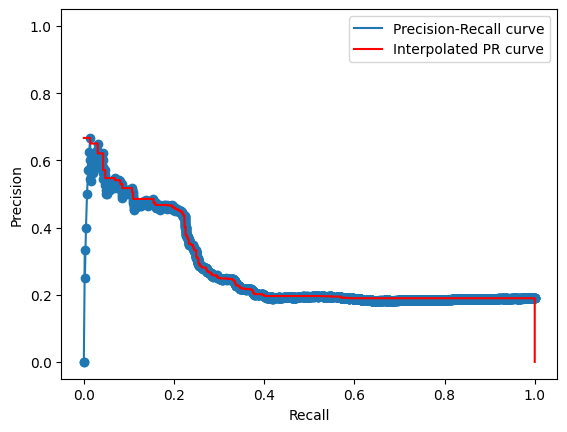

	Query 2


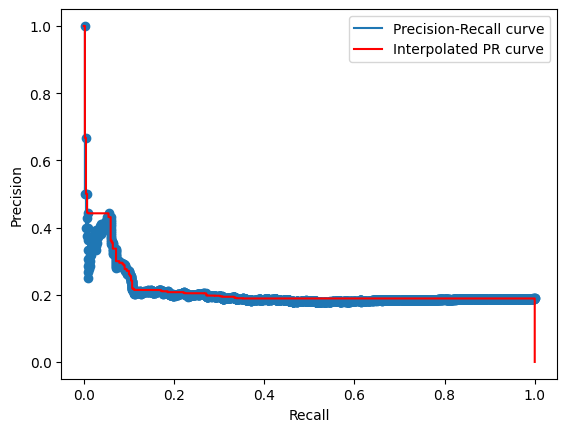

	Query 3


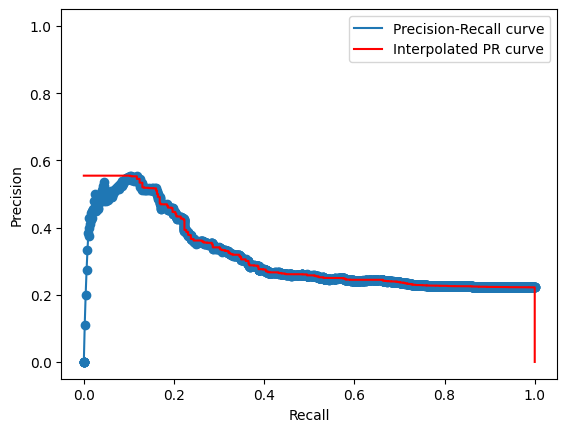

	Query 4


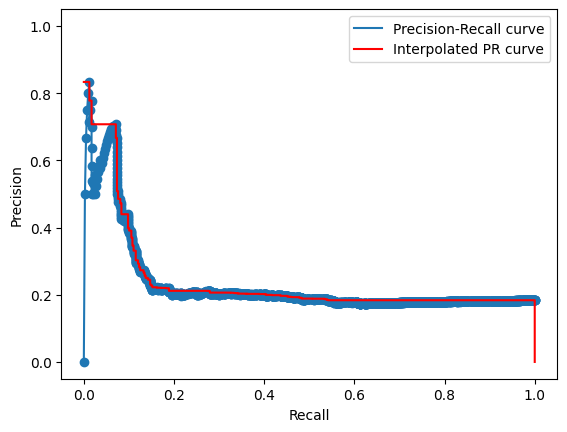

	Query 5


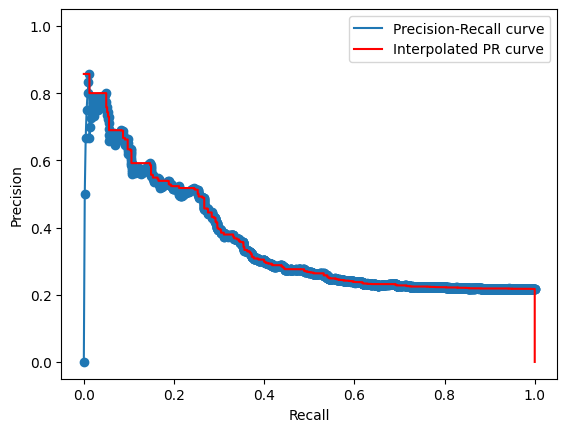

In [28]:
results, relevances = process_results(model, queries_normal)
evaluate(method, results, relevances)

## Results Max word

In [18]:
with open(WORDS_PATH) as f:
    max_words = json.load(f)

In [19]:
queries_max = [ Query(category=c, content=" ".join(max_words[c])) for c in categories]
queries_max

[Query(category='politics', content='show scot fish miliband lindsay houston blackpool phon independ immigr club bbc arrest cunningham heal collin mus sent cre id palestin baa pound schools prim card kewel party soc clim sony bil govern pend cag wag campaign juninho fed post anim fiat ag issu famy robot hagu benefit mr drink bord window rac brit argentin wal edward said britain forens print muslim vot sal santin referend tobacco gam 000 limit iv aid text un jamieson film men kirw 7e7 yahoo stud bank hunt min jap award review deb cel win research broadband barcelon pearc peopl search lvmh e-university off spur brown court deal ballot access col inform pol roch sport asyl afric lord star bry microsoft wait ter jet adv duchy scrushy movy howard jowel fry thanou ukip trust deport childr may casino kilroy-silk us budget liverpool nuclear ba pay parlia company fig new airport prison clos mcal appoint busy uk khan fin podcast law iaaf car osbourn sit yuko mcclaren lib sainsbury coach digit es

Query 1: category='politics' content='show scot fish miliband lindsay houston blackpool phon independ immigr club bbc arrest cunningham heal collin mus sent cre id palestin baa pound schools prim card kewel party soc clim sony bil govern pend cag wag campaign juninho fed post anim fiat ag issu famy robot hagu benefit mr drink bord window rac brit argentin wal edward said britain forens print muslim vot sal santin referend tobacco gam 000 limit iv aid text un jamieson film men kirw 7e7 yahoo stud bank hunt min jap award review deb cel win research broadband barcelon pearc peopl search lvmh e-university off spur brown court deal ballot access col inform pol roch sport asyl afric lord star bry microsoft wait ter jet adv duchy scrushy movy howard jowel fry thanou ukip trust deport childr may casino kilroy-silk us budget liverpool nuclear ba pay parlia company fig new airport prison clos mcal appoint busy uk khan fin podcast law iaaf car osbourn sit yuko mcclaren lib sainsbury coach digit e

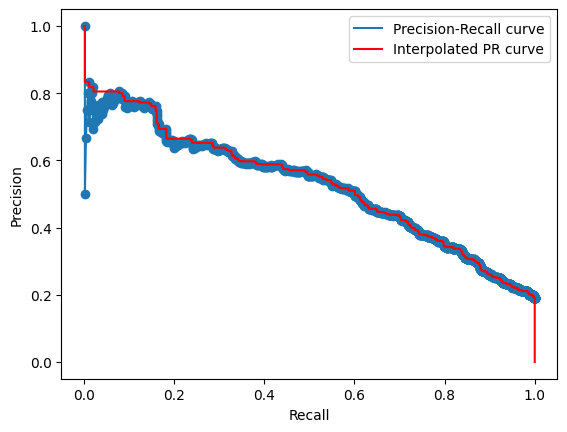

	Query 2


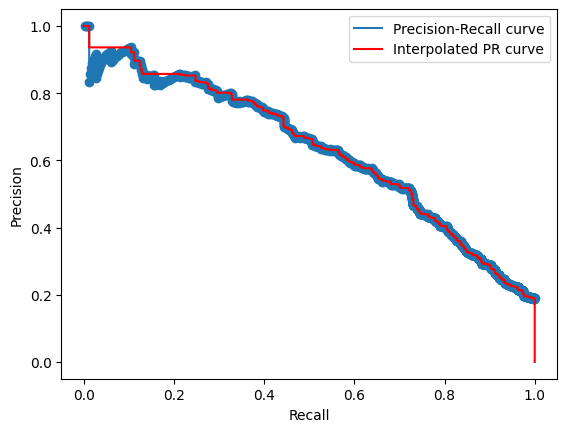

	Query 3


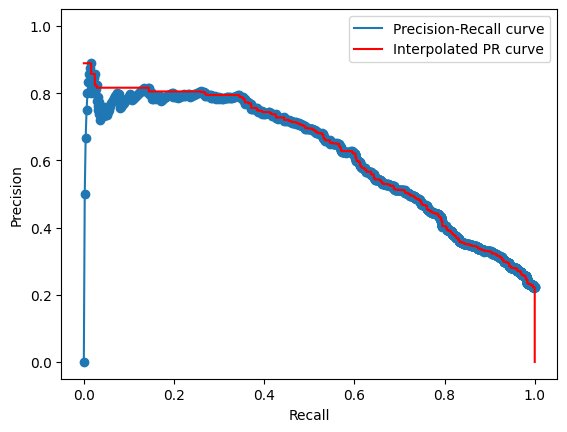

	Query 4


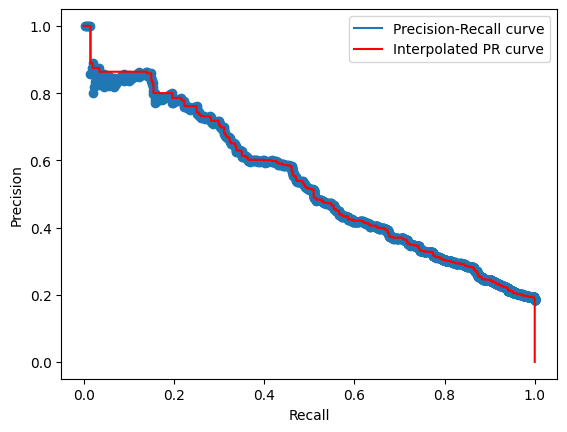

	Query 5


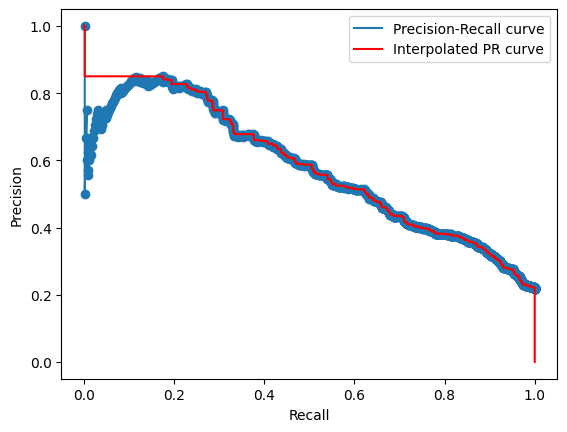

In [29]:
results, relevances = process_results(model, queries_max)
evaluate(method, results, relevances)

method='prec_rec' 
evaluate(method,Q,R)

## Results synonyms chat gpt

In [21]:
with open(WORDS_CHAT_PATH) as f:
    synonyms = json.load(f)

In [22]:
queries_chat = [Query(category=c, content=" ".join(synonyms[c])) for c in categories]
queries_chat

[Query(category='politics', content='government governance statecraft diplomacy ideology policy current affairs public affairs civics activism'),
 Query(category='entertainment', content='amusement fun leisure diversion recreation pastime show business performing arts media pop culture'),
 Query(category='sport', content='play game athletics games competition exercise fitness recreation pastime league championship olympics'),
 Query(category='tech', content='technology innovation engineering science gadgets devices software hardware internet digital'),
 Query(category='business', content='commerce industry trade enterprise company corporation finance economics market profession')]

Query 1: category='politics' content='government governance statecraft diplomacy ideology policy current affairs public affairs civics activism'
 1. [ Score = 0.152 ] Category tech |  ID: 775 | Text: online commons to spark debate online communities 
 2. [ Score = 0.113 ] Category sport |  ID: 1846 | Text: whitehall shredding increasing - tories civil serv
 3. [ Score = 0.106 ] Category politics |  ID: 106 | Text: talks aim to avert pension strike talks aimed at a
 4. [ Score = 0.106 ] Category politics |  ID: 530 | Text: talks aim to avert pension strike talks aimed at a
 5. [ Score = 0.101 ] Category politics |  ID: 67 | Text: stalemate in pension strike talks talks aimed at a
-----
Query 2: category='entertainment' content='amusement fun leisure diversion recreation pastime show business performing arts media pop culture'
 1. [ Score = 0.122 ] Category entertainment |  ID: 1179 | Text: top of the pops leaves bbc one the bbc s flagship 
 2. [ Score = 0.092 ] Category tech |  ID: 1732

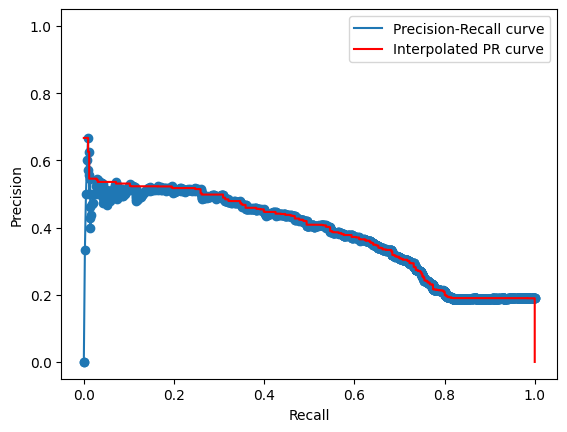

	Query 2


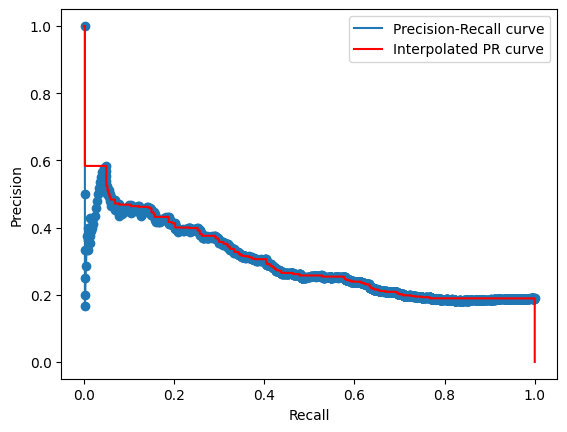

	Query 3


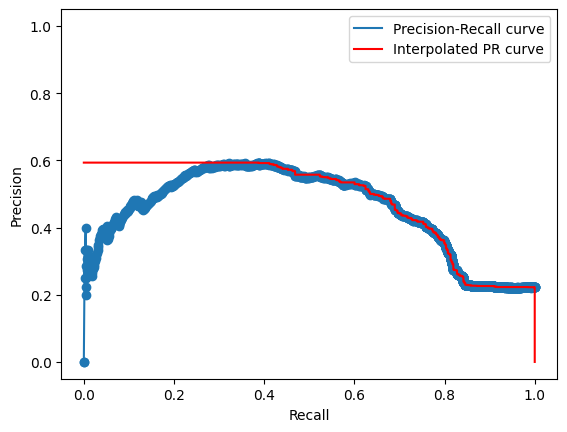

	Query 4


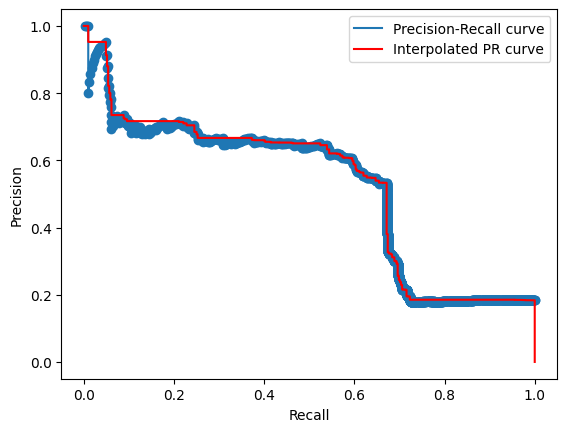

	Query 5


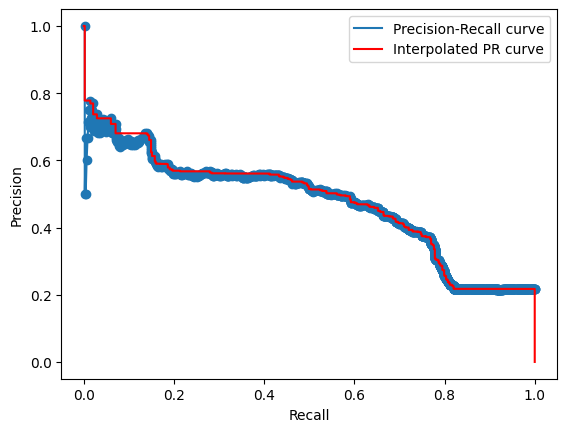

In [30]:
results, relevances = process_results(model, queries_chat)
evaluate(method, results, relevances)